# Lab7: Take home exercise
## st121411

The dataset that I chose is from an sklearn library called make_moons.

In [1]:
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SVMModel:
    
    def linear_kernel(self,x1, x2):
        return np.dot(x1, x2)

    def polynomial_kernel(self,x, y, p=3):
        return (1 + np.dot(x, y)) ** p

    def gaussian_kernel(self,x, y, sigma=1.0):
        return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

    def fit(self, X, y, kernel, C):
        n_samples, n_features = X.shape

        # Gram matrix
        # initialize kernel matrix    
        K = np.zeros((n_samples, n_samples))
        # Kernel matrix

        for i in range(n_samples):
            for j in range(n_samples):
                if kernel == 'linear_kernel':
                    K[i,j] = self.linear_kernel(X[i], X[j])
                elif kernel == 'polynomial_kernel':
                    K[i,j] = self.polynomial_kernel(X[i], X[j])
                else:
                    K[i,j] = self.gaussian_kernel(X[i], X[j])


        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        
        if C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv_idx = a > 1e-5
        ind = np.arange(len(a))[sv_idx]
        a = a[sv_idx]    
        sv = X[sv_idx]
        sv_y = y[sv_idx]
        print("%d support vectors out of %d points" % (len(a), n_samples))

        # Intercept
        b = 0
        for n in range(len(a)):
            b += sv_y[n]
            b -= np.sum(a * sv_y * K[ind[n],sv_idx])
        b /= len(a)

        # Weight vector
        if kernel == 'linear_kernel':
            w = np.zeros(n_features)
            for n in range(len(a)):
                w += a[n] * sv_y[n] * sv[n]
        else:
            w = None
        return sv, sv_y, a, w, b

    def project(self,X, kernel,sv, sv_y, a, w, b):
        if w is not None:
            return np.dot(X, w) + b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a_val, sv_y_val, sv_val in zip(a, sv_y, sv):
                    if kernel == 'polynomial_kernel':
                        s += a_val * sv_y_val * self.polynomial_kernel(X[i], sv_val)
                    else:
                        s += a_val * sv_y_val * self.gaussian_kernel(X[i], sv_val)
                y_predict[i] = s
            return y_predict + b

    def predict(self,X, kernel, sv, sv_y, a, w, b):
        return np.sign(self.project(X, kernel,sv, sv_y, a, w, b))
    
    def plot_contour(self,X1_train, X2_train, kernel, sv, sv_y, a, w, b):
        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(sv[:,0], sv[:,1], s=100, c="g")
        # here we choose the range between -7 and 7 as we have choosen
        # the mean to be between -4 and 4 while generating data with the variance of 0.8
        X1, X2 = np.meshgrid(np.linspace(-7,7,50), np.linspace(-7,7,50))
        X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
        Z = self.project(X, kernel,sv, sv_y, a, w, b).reshape(X1.shape)
        pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
        pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

        pl.axis("tight")
        pl.show()

In [3]:
from sklearn import datasets

In [4]:
X,y = datasets.make_moons(n_samples=200, noise=.30,shuffle=False)
y[y==0] = -1
y = y.astype(float)

Text(0.5, 1.0, 'Noisy Moons')

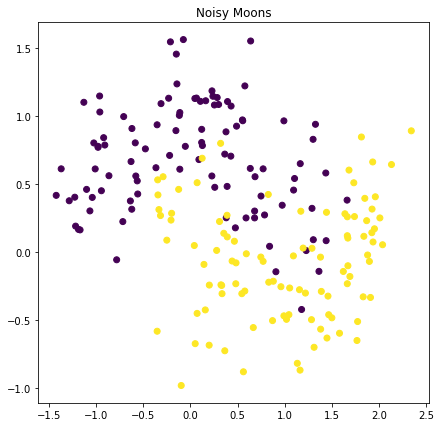

In [5]:
plt.figure(figsize=(7,7))
plt.scatter(X[:,0],X[:,1],c=y)
plt.title("Noisy Moons")

     pcost       dcost       gap    pres   dres
 0:  3.4844e+06 -5.6162e+07  7e+07  8e-02  2e-12
 1:  1.4377e+06 -7.6665e+06  1e+07  9e-03  2e-12
 2:  2.6008e+05 -1.6177e+06  2e+06  1e-03  2e-12
 3:  1.2975e+04 -3.7380e+05  4e+05  1e-04  2e-12
 4: -1.7079e+04 -1.1078e+05  9e+04  2e-05  2e-12
 5: -2.4424e+04 -7.8831e+04  5e+04  8e-06  2e-12
 6: -2.7536e+04 -6.6134e+04  4e+04  5e-06  2e-12
 7: -3.0412e+04 -5.6462e+04  3e+04  3e-06  2e-12
 8: -3.2909e+04 -4.6716e+04  1e+04  8e-07  2e-12
 9: -3.4390e+04 -4.3464e+04  9e+03  4e-07  2e-12
10: -3.5400e+04 -4.0076e+04  5e+03  1e-07  2e-12
11: -3.5825e+04 -3.8661e+04  3e+03  5e-08  2e-12
12: -3.6190e+04 -3.7692e+04  2e+03  2e-08  2e-12
13: -3.6523e+04 -3.6904e+04  4e+02  1e-12  2e-12
14: -3.6634e+04 -3.6730e+04  1e+02  2e-11  2e-12
15: -3.6668e+04 -3.6679e+04  1e+01  2e-11  2e-12
16: -3.6672e+04 -3.6674e+04  1e+00  2e-12  3e-12
17: -3.6673e+04 -3.6673e+04  8e-02  2e-12  3e-12
18: -3.6673e+04 -3.6673e+04  1e-03  1e-11  3e-12
Optimal solution foun

(-2.0, 3.0)

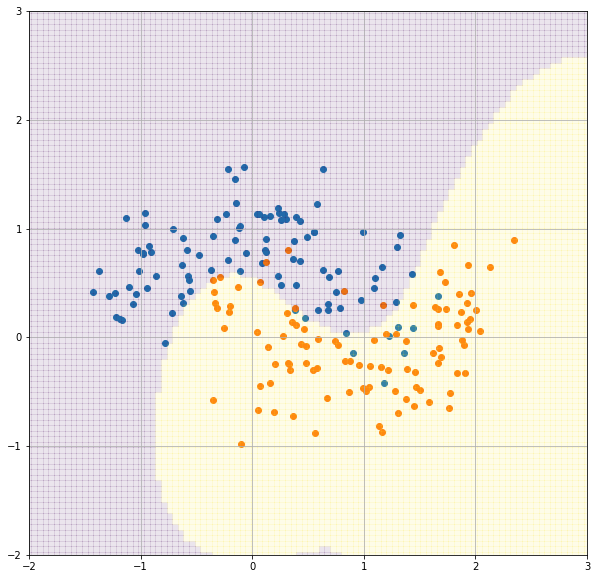

In [6]:
SVM = SVMModel()

kernel = 'gaussian_kernel'

sv, sv_y, a, w, b = SVM.fit(X,y,kernel=kernel,C=1000)

resolution = 100
x_series = np.linspace(-2,3,resolution)
y_series = np.linspace(-2,3,resolution)

x_mesh,y_mesh = np.meshgrid(x_series,y_series)

x_mesh = x_mesh.reshape(-1,1)
y_mesh = y_mesh.reshape(-1,1)

mesh = np.append(x_mesh,y_mesh,axis=1)
y_pred = SVM.predict(mesh,kernel,sv,sv_y,a,w,b).astype(int)

x_mesh = x_mesh.reshape(resolution,resolution)
y_mesh = y_mesh.reshape(resolution,resolution)
y_pred = y_pred.reshape(resolution,resolution)

plt.figure(figsize=(10,10))
plt.scatter(X[:100,0],X[:100,1])
plt.scatter(X[100:,0],X[100:,1])
plt.pcolormesh(x_mesh,y_mesh,y_pred,cmap='viridis',shading='auto',alpha=0.1)
plt.grid(True)
plt.xlim([-2,3])
plt.ylim([-2,3])

     pcost       dcost       gap    pres   dres
 0: -4.0798e+01 -4.6246e+01  1e+03  3e+01  2e-15
 1: -9.9944e+00 -4.3052e+01  7e+01  6e-01  2e-15
 2: -8.6672e+00 -1.6682e+01  8e+00  2e-15  9e-16
 3: -9.4063e+00 -1.1070e+01  2e+00  2e-16  6e-16
 4: -9.8496e+00 -1.0209e+01  4e-01  4e-16  6e-16
 5: -9.9779e+00 -1.0051e+01  7e-02  4e-15  6e-16
 6: -1.0003e+01 -1.0021e+01  2e-02  3e-15  6e-16
 7: -1.0010e+01 -1.0013e+01  3e-03  5e-16  6e-16
 8: -1.0011e+01 -1.0011e+01  2e-04  2e-15  7e-16
 9: -1.0011e+01 -1.0011e+01  2e-06  2e-16  7e-16
Optimal solution found.
128 support vectors out of 200 points


(-2.0, 3.0)

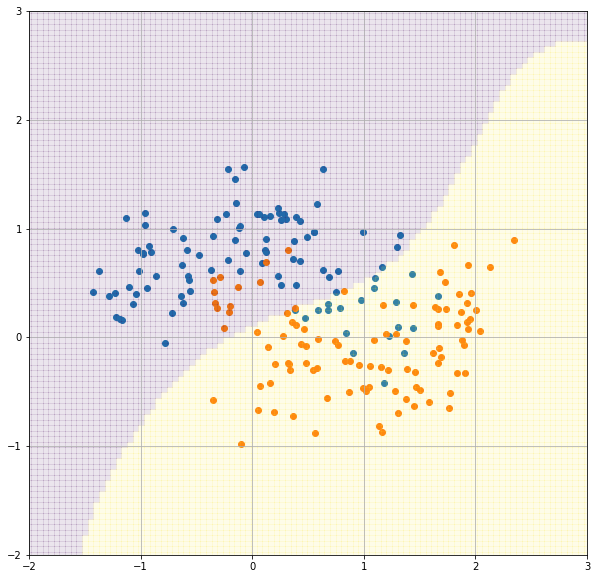

In [7]:
kernel = 'gaussian_kernel'

sv, sv_y, a, w, b = SVM.fit(X,y,kernel=kernel,C=0.1)

resolution = 100
x_series = np.linspace(-2,3,resolution)
y_series = np.linspace(-2,3,resolution)

x_mesh,y_mesh = np.meshgrid(x_series,y_series)

x_mesh = x_mesh.reshape(-1,1)
y_mesh = y_mesh.reshape(-1,1)

mesh = np.append(x_mesh,y_mesh,axis=1)
y_pred = SVM.predict(mesh,kernel,sv,sv_y,a,w,b).astype(int)

x_mesh = x_mesh.reshape(resolution,resolution)
y_mesh = y_mesh.reshape(resolution,resolution)
y_pred = y_pred.reshape(resolution,resolution)

plt.figure(figsize=(10,10))
plt.scatter(X[:100,0],X[:100,1])
plt.scatter(X[100:,0],X[100:,1])
plt.pcolormesh(x_mesh,y_mesh,y_pred,cmap='viridis',shading='auto',alpha=0.1)
plt.grid(True)
plt.xlim([-2,3])
plt.ylim([-2,3])

     pcost       dcost       gap    pres   dres
 0:  5.8648e+05 -1.3035e+08  3e+08  7e-01  5e-11
 1:  1.1987e+06 -5.4697e+07  8e+07  1e-01  5e-11
 2:  9.4067e+05 -1.1661e+07  1e+07  2e-02  4e-11
 3:  1.4092e+05 -2.5495e+06  3e+06  2e-03  4e-11
 4: -1.3890e+04 -3.5113e+05  3e+05  1e-04  4e-11
 5: -2.4846e+04 -9.7708e+04  7e+04  3e-05  4e-11
 6: -2.8910e+04 -8.6698e+04  6e+04  2e-05  4e-11
 7: -3.2634e+04 -7.1528e+04  4e+04  1e-05  3e-11
 8: -3.4920e+04 -5.8763e+04  2e+04  5e-06  5e-11
 9: -3.6501e+04 -5.1179e+04  1e+04  3e-06  4e-11
10: -3.7643e+04 -4.8414e+04  1e+04  1e-06  4e-11
11: -3.8205e+04 -4.4756e+04  7e+03  3e-07  4e-11
12: -3.9571e+04 -4.2256e+04  3e+03  3e-08  5e-11
13: -4.0359e+04 -4.0877e+04  5e+02  2e-09  5e-11
14: -4.0495e+04 -4.0669e+04  2e+02  8e-10  5e-11
15: -4.0552e+04 -4.0577e+04  3e+01  6e-11  6e-11
16: -4.0563e+04 -4.0563e+04  3e-01  2e-11  6e-11
17: -4.0563e+04 -4.0563e+04  3e-03  1e-11  5e-11
Optimal solution found.
70 support vectors out of 200 points


(-2.0, 3.0)

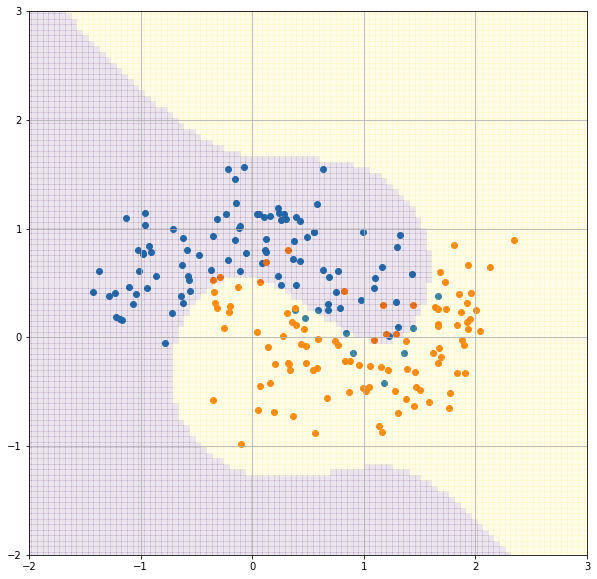

In [8]:
SVM = SVMModel()

kernel = 'polynomial_kernel'

sv, sv_y, a, w, b = SVM.fit(X,y,kernel=kernel,C=1000)

resolution = 100
x_series = np.linspace(-2,3,resolution)
y_series = np.linspace(-2,3,resolution)

x_mesh,y_mesh = np.meshgrid(x_series,y_series)

x_mesh = x_mesh.reshape(-1,1)
y_mesh = y_mesh.reshape(-1,1)

mesh = np.append(x_mesh,y_mesh,axis=1)
y_pred = SVM.predict(mesh,kernel,sv,sv_y,a,w,b).astype(int)

x_mesh = x_mesh.reshape(resolution,resolution)
y_mesh = y_mesh.reshape(resolution,resolution)
y_pred = y_pred.reshape(resolution,resolution)

plt.figure(figsize=(10,10))
plt.scatter(X[:100,0],X[:100,1])
plt.scatter(X[100:,0],X[100:,1])
plt.pcolormesh(x_mesh,y_mesh,y_pred,cmap='viridis',shading='auto',alpha=0.1)
plt.grid(True)
plt.xlim([-2,3])
plt.ylim([-2,3])

     pcost       dcost       gap    pres   dres
 0: -3.9959e+01 -4.2847e+01  1e+03  3e+01  4e-14
 1: -7.6367e+00 -4.0177e+01  1e+02  1e+00  5e-14
 2: -5.6589e+00 -2.3167e+01  3e+01  2e-01  1e-14
 3: -5.8334e+00 -8.4523e+00  3e+00  2e-02  6e-15
 4: -6.5788e+00 -7.3379e+00  8e-01  4e-03  8e-15
 5: -6.7933e+00 -7.0249e+00  2e-01  1e-03  6e-15
 6: -6.8594e+00 -6.9441e+00  9e-02  3e-04  7e-15
 7: -6.8827e+00 -6.9143e+00  3e-02  7e-05  7e-15
 8: -6.8935e+00 -6.9020e+00  9e-03  1e-05  7e-15
 9: -6.8974e+00 -6.8977e+00  3e-04  8e-08  7e-15
10: -6.8975e+00 -6.8976e+00  3e-06  8e-10  8e-15
Optimal solution found.
80 support vectors out of 200 points


(-2.0, 3.0)

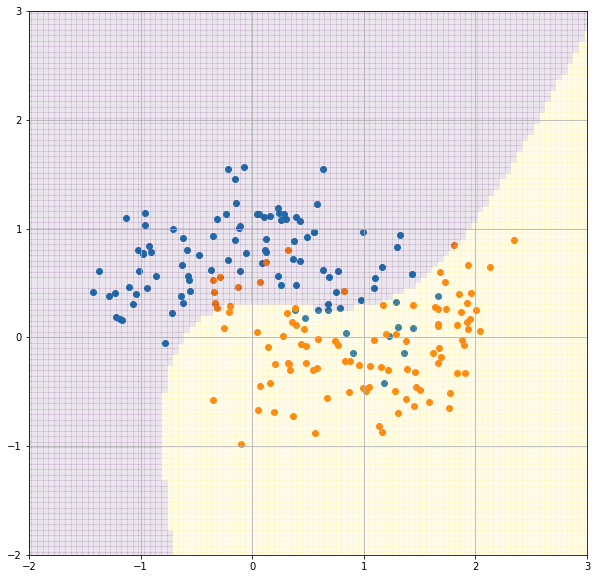

In [11]:
SVM = SVMModel()

kernel = 'polynomial_kernel'

sv, sv_y, a, w, b = SVM.fit(X,y,kernel=kernel,C=0.1)

resolution = 100
x_series = np.linspace(-2,3,resolution)
y_series = np.linspace(-2,3,resolution)

x_mesh,y_mesh = np.meshgrid(x_series,y_series)

x_mesh = x_mesh.reshape(-1,1)
y_mesh = y_mesh.reshape(-1,1)

mesh = np.append(x_mesh,y_mesh,axis=1)
y_pred = SVM.predict(mesh,kernel,sv,sv_y,a,w,b).astype(int)

x_mesh = x_mesh.reshape(resolution,resolution)
y_mesh = y_mesh.reshape(resolution,resolution)
y_pred = y_pred.reshape(resolution,resolution)

plt.figure(figsize=(10,10))
plt.scatter(X[:100,0],X[:100,1])
plt.scatter(X[100:,0],X[100:,1])
plt.pcolormesh(x_mesh,y_mesh,y_pred,cmap='viridis',shading='auto',alpha=0.1)
plt.grid(True)
plt.xlim([-2,3])
plt.ylim([-2,3])

     pcost       dcost       gap    pres   dres
 0: -7.1973e+01 -2.0671e+02  1e+03  3e+01  3e+00
 1: -3.3322e+02 -5.9285e+02  8e+02  2e+01  2e+00
 2: -6.6299e+02 -1.0756e+03  8e+02  2e+01  2e+00
 3: -1.9091e+03 -2.5570e+03  8e+02  1e+01  1e+00
 4: -6.6420e+03 -7.7774e+03  1e+03  1e+01  1e+00
 5: -1.9658e+04 -2.2065e+04  2e+03  1e+01  1e+00
 6: -6.2583e+04 -6.8414e+04  6e+03  1e+01  1e+00
 7: -1.9686e+05 -2.1183e+05  1e+04  1e+01  1e+00
 8: -6.6327e+05 -7.0523e+05  4e+04  1e+01  1e+00
 9: -1.8779e+06 -1.9837e+06  1e+05  1e+01  1e+00
10: -1.8781e+06 -1.9839e+06  1e+05  1e+01  1e+00
11: -5.3597e+06 -5.6318e+06  3e+05  1e+01  1e+00
12: -5.3601e+06 -5.6322e+06  3e+05  1e+01  1e+00
13: -6.0644e+07 -6.2185e+07  2e+06  1e+01  1e+00
14: -6.1343e+08 -6.2549e+08  1e+07  1e+01  1e+00
15: -6.1397e+08 -6.2604e+08  1e+07  1e+01  1e+00
16: -2.6544e+10 -2.6641e+10  1e+08  1e+01  1e+00
17: -3.3422e+10 -3.3544e+10  1e+08  1e+01  1e+00
18: -4.7044e+10 -4.7216e+10  2e+08  1e+01  1e+00
19: -1.0375e+11 -1.04

(-2.0, 3.0)

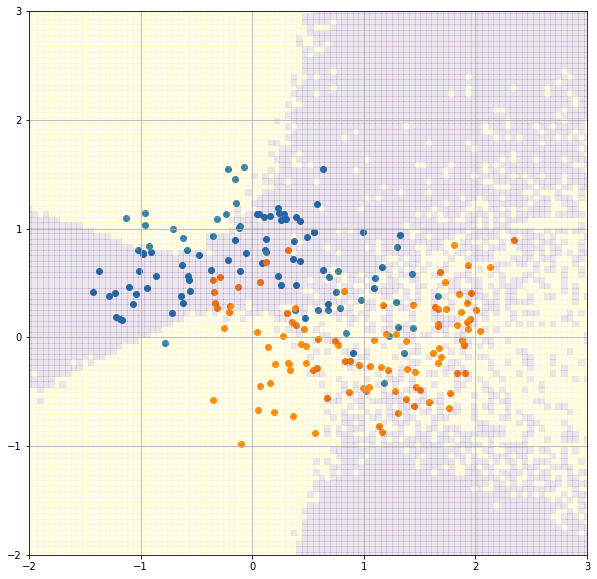

In [12]:
SVM = SVMModel()

kernel = 'polynomial_kernel'

sv, sv_y, a, w, b = SVM.fit(X,y,kernel=kernel,C=None)

resolution = 100
x_series = np.linspace(-2,3,resolution)
y_series = np.linspace(-2,3,resolution)

x_mesh,y_mesh = np.meshgrid(x_series,y_series)

x_mesh = x_mesh.reshape(-1,1)
y_mesh = y_mesh.reshape(-1,1)

mesh = np.append(x_mesh,y_mesh,axis=1)
y_pred = SVM.predict(mesh,kernel,sv,sv_y,a,w,b).astype(int)

x_mesh = x_mesh.reshape(resolution,resolution)
y_mesh = y_mesh.reshape(resolution,resolution)
y_pred = y_pred.reshape(resolution,resolution)

plt.figure(figsize=(10,10))
plt.scatter(X[:100,0],X[:100,1])
plt.scatter(X[100:,0],X[100:,1])
plt.pcolormesh(x_mesh,y_mesh,y_pred,cmap='viridis',shading='auto',alpha=0.1)
plt.grid(True)
plt.xlim([-2,3])
plt.ylim([-2,3])

In this lab, I tried different kernels to fit the moons dataset. For the gaussian kernel, I tried a value of C of 1000 and 0.1 to see compare and contrast between different values of the slack variables. It could be seen that with C = 0.1, the errors do not really make much effect on the minimization of the cost, therefore, a very simple smooth line was created between the two classes that didn't seem to be a very good classification line. Whereas for C=1000, it could be seen that the curves were much more sharp (because of the heavier cost on the errors) therefore making it a more suitable slack variable for this dataset. When the slack variable was set to None, the optimization always terminated before it was able to find the optimal point. 
As for the polynomial kernel, I did a similar experiment in which I changed the value of the slack variables from 1000 to 0.1 to None. Similar to using a gaussian model, C=1000 performed better than C=0.1 as it was able to create a sharper curve between the boundaries of the two  datasets. But unlike the gaussian kernel, not using the slack variable did result in an optimum, but the optimum was clearly overfitted because all the datasets were used as support vectors and from the color mesh graph, it could be seen that the classification is really erratic and has lots of spots. 